In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score



In [2]:
#global variables


SEED = 42

FOLDS = 10

FILEPATH = '../data/'

In [3]:
test = pd.read_csv(f'{FILEPATH}test.csv')
train = pd.read_csv(f'{FILEPATH}train.csv')

In [ ]:
def analyze_dataframe(df):
    """
    Analyze a pandas DataFrame and provide a summary of its characteristics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
    None
    """
    print("DataFrame Information:")
    print("______________________")
    display(df.info(verbose=True, show_counts=True))
    print("\n")
    
    print("DataFrame Head:")
    print("______________________")
    display(df.head())
    print("\n")

    print("DataFrame Tail:")
    print("______________________")
    display(df.tail())
    print("\n")

    print("DataFrame Description:")
    print("______________________")
    display(df.describe().T)
    print("\n")

    print("Number of Null Values:")
    print("______________________")
    display(df.isnull().sum())
    print("\n")

    print("Number of Duplicated Rows:")
    print("______________________")
    display(df.duplicated().sum())
    print("\n")

    print("Number of Unique Values:")
    print("______________________")
    display(df.nunique())
    print("\n")

    print("DataFrame Shape:")
    print("______________________")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n")
    
    print("DataFrame Columns:")
    print("______________________")
    display(df.columns)
    

analyze_dataframe(train)

In [4]:
def preprocess_data(df, num_features, scaler):
    # Normalize numerical features if num_features is not empty
    if num_features:  # Check if num_features list is not empty
        df[num_features] = scaler.fit_transform(df[num_features])
    
    df = df.drop(columns=['id'])
    return df

In [5]:
cat_features = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "SMOKE",
    "SCC",
    "CALC",
    "MTRANS",
]
num_features = [
    "Age",
    "Height",
    "Weight",
    "FCVC",
    "NCP",
    "CH2O",
    "FAF",
    "TUE",
]


In [6]:
scaler = StandardScaler()

# Preprocess the data
train_df = preprocess_data(train, num_features, scaler)
test_df = preprocess_data(test, num_features, scaler)

X = train_df.drop(columns=["NObeyesdad"])
y = train_df["NObeyesdad"]

skf = StratifiedKFold(n_splits=FOLDS, random_state=SEED, shuffle=True)

catboost_model = CatBoostClassifier(
    loss_function='MultiClass', 
    verbose=100,  
    random_seed=SEED  
)

# Identify categorical features in your dataset
# This is necessary because CatBoost needs to know which columns are categorical
categorical_features_indices = [train_df.columns.get_loc(c) for c in cat_features if c in train_df]

# Perform stratified k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold+1}")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model
    catboost_model.fit(
        X_train, y_train,
        cat_features=categorical_features_indices, 
        eval_set=(X_val, y_val),
        early_stopping_rounds=50 
    )

    # Make predictions on the validation set
    y_pred_val = catboost_model.predict(X_val)

    # Calculate accuracy
    accuracy_val = accuracy_score(y_val, y_pred_val)
    print(f'Validation Accuracy: {accuracy_val}')
    print("\n")


Fold: 1
Learning rate set to 0.114487
0:	learn: 1.5874807	test: 1.5841897	best: 1.5841897 (0)	total: 237ms	remaining: 3m 56s
100:	learn: 0.2898489	test: 0.3139299	best: 0.3139299 (100)	total: 12.2s	remaining: 1m 48s
200:	learn: 0.2461231	test: 0.2858839	best: 0.2858839 (200)	total: 24.1s	remaining: 1m 35s
300:	learn: 0.2251550	test: 0.2775971	best: 0.2775971 (300)	total: 35.7s	remaining: 1m 22s
400:	learn: 0.2099011	test: 0.2731873	best: 0.2731873 (400)	total: 46.9s	remaining: 1m 10s
500:	learn: 0.1966024	test: 0.2701624	best: 0.2701624 (500)	total: 58.7s	remaining: 58.5s
600:	learn: 0.1839128	test: 0.2677782	best: 0.2677782 (600)	total: 1m 10s	remaining: 46.5s
700:	learn: 0.1728680	test: 0.2646170	best: 0.2646170 (700)	total: 1m 21s	remaining: 34.8s
800:	learn: 0.1619420	test: 0.2630183	best: 0.2626731 (772)	total: 1m 33s	remaining: 23.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2626730918
bestIteration = 772

Shrink model to first 773 iterations.
Validation

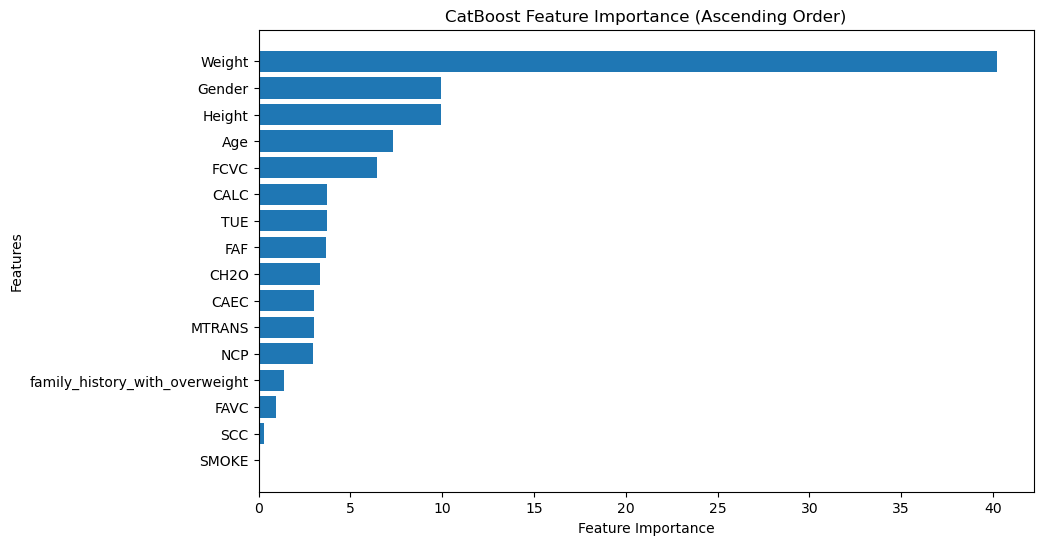

In [7]:
import matplotlib.pyplot as plt

feature_importance = catboost_model.get_feature_importance()
feature_names = train_df.drop(columns=["NObeyesdad"]).columns

# Sort the feature importance and feature names in ascending order
sorted_indices = feature_importance.argsort()
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance (Ascending Order)')
plt.show()


# Submission

In [8]:

test_df = preprocess_data(test, num_features, scaler)
y_pred_test = catboost_model.predict(test_df)


submission_df = pd.DataFrame({
    'id': test['id'],  # Ensure this is correctly referencing the IDs from your original test dataset
    'NObeyesdad': y_pred_test.flatten()  # Flatten in case the output is in a single-column array
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission DataFrame
display(submission_df.head())
display(submission_df.shape)



,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


(13840, 2)